# High throughput calculations

## Singlepoint

In [1]:
from aiida import load_profile
load_profile()

Profile<uuid='468a9d4d0812492ba52462f2aca53e23' name='presto'>

We need to choose a model and architecture to be used for the calculation and save it as ModelData type, a specific data type of this plugin.
In this example we use MACE with a model that we download from this URL: "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model", and we save the file in the cache folder (default="~/.cache/mlips/"):


In [2]:
from aiida_mlip.data.model import ModelData
uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp", cache_dir="mlips")

If we already have the model saved in some folder we can save it as:

In [3]:
# model = ModelData.from_local("/path/to/model", architecture="mace")

Another parameter that we need to define as AiiDA type is the code. Assuming the code is saved as `janus` in the `localhost` computer, the code info that are needed can be loaded as follow:


In [4]:
from aiida.orm import load_code
code = load_code("janus@localhost")

Inputs should include the model, code, metadata, and any other keyword arguments expected by the calculation we are running:

In [5]:
inputs = {
    "model": model,
    "metadata": {"options": {"resources": {"num_machines": 1}}},
    "code": code,
    "properties": "energy",
}

We must also choose the calculation to perform:

In [6]:
from aiida.plugins import CalculationFactory
SinglepointCalc = CalculationFactory("mlip.sp")

Then we get create our WorkGraph. This requires setting the calculation to be performed, the folder containing the files run the calculations on, inputs expected by the calculation, and the key to access the final structure from the calculations:

In [7]:
from pathlib import Path

from aiida_mlip.workflows.ht_workgraph import get_ht_workgraph

wg = get_ht_workgraph(
    calc=SinglepointCalc,
    folder=Path("/home/mtr46585/aiida-mlip/tests/workflows/structures/"),
    calc_inputs=inputs,
    final_struct_key="xyz_output",
)

In [ ]:
from aiida_mlip.workflows.ht_workgraph import aggregate_task_output

wg = aggregate_task_output()

In [8]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'ht_calc…

Now we can run the calculations:

In [9]:
wg.run()

07/01/2025 11:00:30 AM <46813> aiida.broker.rabbitmq: [WARNING] RabbitMQ v3.12.1 is not supported and will cause unexpected problems!
07/01/2025 11:00:30 AM <46813> aiida.broker.rabbitmq: [WARNING] It can cause long-running workflows to crash and jobs to be submitted multiple times.
07/01/2025 11:00:30 AM <46813> aiida.broker.rabbitmq: [WARNING] See https://github.com/aiidateam/aiida-core/wiki/RabbitMQ-version-to-use for details.
07/01/2025 11:00:31 AM <46813> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [898|WorkGraphEngine|continue_workgraph]: tasks ready to run: ht_calc


defining outputnode
calc_H2O
{'structs.H2O': 'xyz_output'}
calc_methane
{'structs.methane': 'xyz_output'}


07/01/2025 11:00:32 AM <46813> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [898|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 901
07/01/2025 11:00:30 AM <46813> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [901|WorkGraphEngine|continue_workgraph]: tasks ready to run: calc_H2O,calc_methane
07/01/2025 11:00:31 AM <46813> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [901|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 905, 909
07/01/2025 11:00:49 AM <46813> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [901|WorkGraphEngine|update_task_state]: Task: calc_H2O, type: CALCJOB, finished.
07/01/2025 11:00:49 AM <46813> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [901|WorkGraphEngine|update_task_state]: Task: calc_methane, type: CALCJOB, finished.
07/01/2025 11:00:49 AM <46813> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REP

In [ ]:
wg.tasks.ht_calc.inputs

NodeGraphWidget(positions={'build_ht_calc': [30, 30]}, settings={'minmap': False}, style={'width': '80%', 'hei…

The full graph can be visualised:

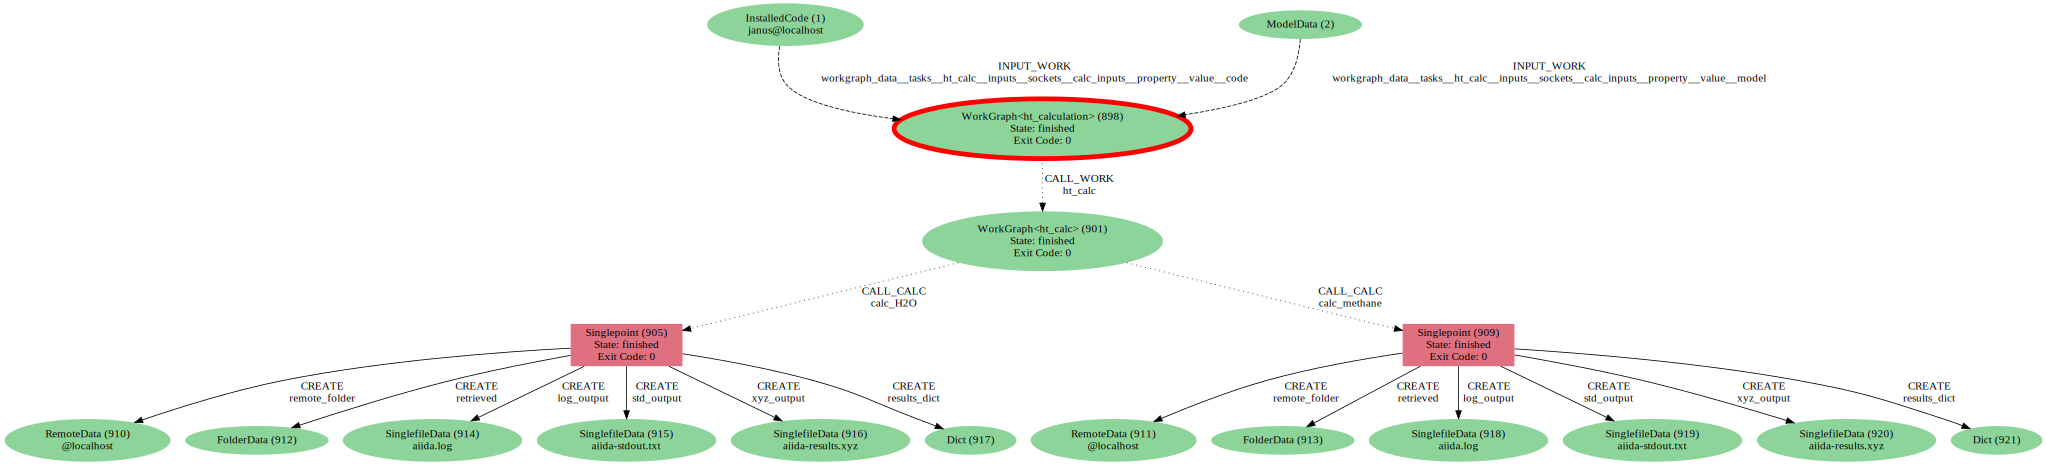

In [12]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg.pk)

If using `wg.submit()` instead of `wg.run()`, calculations may still running, even when setting `wait=True`, due to a timeout. The WorkGraph's state can be updated:

In [13]:
wg.update()
wg.state

'FINISHED'

The final structures can then be accessed:

In [18]:
wg.tasks.ht_calc.inputs.final_struct_key

SocketAny(name='final_struct_key', value=xyz_output)

## Geometry optimisation

Similarly, high throughput geometry optimisation can be performed by changing the `calc`:

In [ ]:
from aiida.plugins import CalculationFactory
GeomoptCalc = CalculationFactory("mlip.opt")

wg = get_ht_workgraph(
    calc=GeomoptCalc,
    folder=Path("../../tests/workflows/structures/"),
    calc_inputs=inputs,
    final_struct_key="final_structure",
)

In [ ]:
wg.run()

The full graph can be visualised:

In [ ]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg.pk)

The final structures produced can then be accessed:

In [ ]:
wg.process.outputs.final_structures.H2O